# Introduction
This notebook analyzes all traffic signs in Pittsburgh from 2021 (unfortunatly, there's not newer dataset). For each neighborhood, I assigned its total amount of signs using spatial join. I finally visualize the results using choropleth maps by giving a unique color to each kind of traffic sign. I did all of this to probe at a neighborhood's expected average congestion in the roads.

In [1]:
import pandas as pd
traffic_signs = pd.read_csv("https://data.wprdc.org/datastore/dump/d078a6b5-83a3-4723-a3a9-5371cfe1cc0c")
traffic_signs.head()

,_id,id,mutcd_code,address_number,street,city,mounting_fixture,date_installed,description,neighborhood,council_district,ward,tract,public_works_division,pli_division,police_zone,fire_zone,latitude,longitude
0,1,1673225887,R1-1,900,California Ave,Pittsburgh,Wood Pole,NaN,Stop,California-Kirkbride,6.0,25.0,4.200325e+10,1.0,25.0,1.0,1-9,40.459325,-80.019057
1,2,668379452,R1-1,107,Glenbury St,Pittsburgh,Channel,NaN,Stop,Overbrook,4.0,32.0,4.200332e+10,5.0,32.0,3.0,4-25,40.386955,-80.002161
2,3,174468442,R1-1,5325,Forbes Ave,Pittsburgh,Wood Pole,NaN,Stop,Squirrel Hill North,8.0,14.0,4.200314e+10,3.0,14.0,4.0,2-8,40.439828,-79.934814
3,4,1517107112,R1-1,1437,N St Clair St,Pittsburgh,Channel,NaN,Stop,Highland Park,7.0,11.0,4.200311e+10,2.0,11.0,5.0,3-9,40.478685,-79.919270
4,5,1374142598,WF,228,Isabella St,Pittsburgh,Metal Pole,1995-02-14,Wayfinding Signage,North Shore,1.0,22.0,4.200356e+10,6.0,22.0,1.0,1-20,40.448482,-80.000671


# Data Visualization

<Axes: >

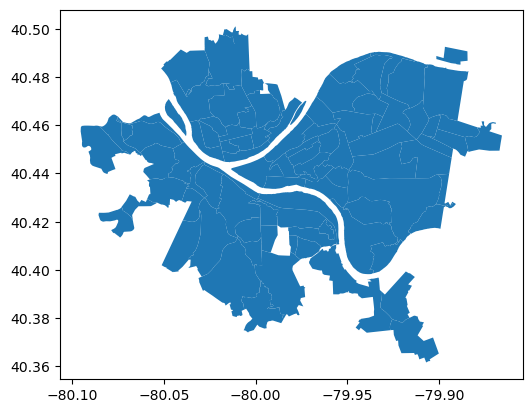

In [15]:
import geopandas
import matplotlib.pyplot as plt
neighborhoods = geopandas.read_file("Neighborhoods/Neighborhoods_.shp")
neighborhoods.plot()

Convert the latitude and longitude data in city_traffic_signs.csv to Point data that can be read by Shapely.

In [16]:
from shapely.geometry import Point
geometry = [Point(xy) for xy in zip(traffic_signs["longitude"], traffic_signs["latitude"])]
gdf_ts = geopandas.GeoDataFrame(traffic_signs, geometry=geometry, crs="EPSG:4326")

Convert traffic signs into geometry data. Assigning every sign location to each neighborhood.

In [12]:
neighborhoods = neighborhoods.to_crs("EPSG:4326")
traffic_signs_neighborhood = geopandas.sjoin(gdf_ts, neighborhoods, how="left", predicate="within")

Get the statistics for the amount of stop, pedestrian, and yield signs.

In [21]:
sign_amount = traffic_signs_neighborhood.groupby("hood").size().reset_index(name="SignAmount")
sign_amount = sign_amount.sort_values("SignAmount", ascending=False)
sign_amount.head()

,hood,SignAmount
71,South Side Flats,3672
9,Bloomfield,3627
16,Central Business District,3491
67,Shadyside,3370
76,Squirrel Hill South,3281


In [20]:
sign_amount.tail()

,hood,SignAmount
77,St. Clair,64
66,Ridgemont,62
20,Chartiers City,44
35,Glen Hazel,38
4,Arlington Heights,21


Return said amounts and map them.

<Axes: >

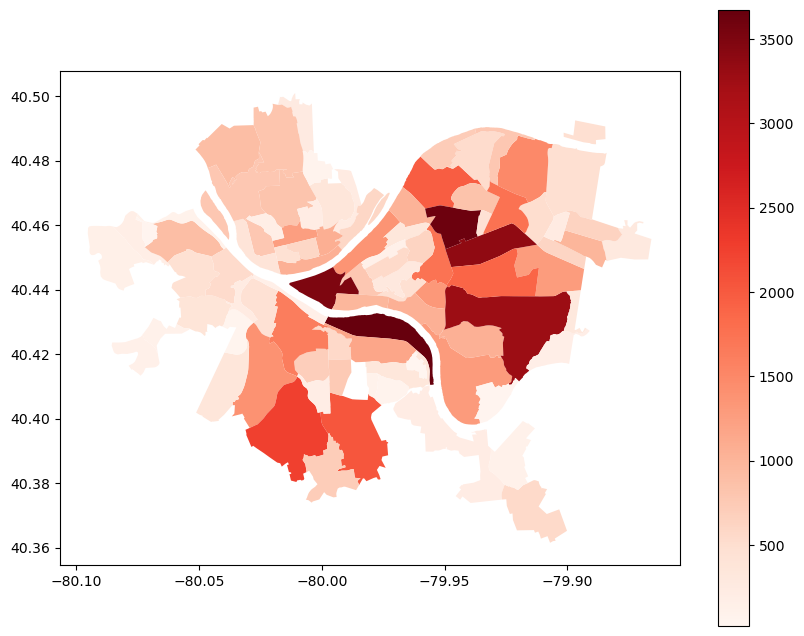

In [18]:
neighborhoods = neighborhoods.merge(sign_amount, on="hood", how="left")
neighborhoods["SignAmount"] = neighborhoods["SignAmount"].fillna(0)
neighborhoods.plot(column="SignAmount", cmap="Reds", legend=True, figsize=(10,8))

# Conclusion

Based on the city traffic sign data from WPRDC, I assigned each neighborhood its total amount of signs. This was to guage at the expected road congestion at each neighborhood.
Based on the analysis, the top 3 neighborhoods with the least expected congestions are:

1. Arlington Heights
2. Glen Hazel
3. Chartiers City

This sumetric will be factored into other submetrics in ultimately evaluating the best neighborhood. However, it will obviously be weighted less compared to household income and safety.

Generate a .cvs file that only includes the neighborhoods and their corresponding total number of traffic signs.

In [25]:
traffic_signs_df = neighborhoods[["hood", "SignAmount"]]
traffic_signs_df.head()

,hood,SignAmount
0,Central Oakland,1327
1,North Oakland,1743
2,West Oakland,486
3,Crawford-Roberts,784
4,Strip District,1366


In [26]:
traffic_signs_df.to_csv("traffic_signs_total.csv", index=False)